In [16]:
from llm import  VANILLA_ATTENTIONS_PATH, PROMPT_ATTENTIONS_PATH, ADDING_ATTENTIONS_PATH, VANILLA_TOKENS_PATH, PROMPT_TOKENS_PATH, ADDING_TOKENS_PATH

from typing import List, Tuple, Optional
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import torch
import networkx as nx

In [29]:
list(np.array([[1,2,3,4], [5,6,7,8]]))

[array([1, 2, 3, 4]), array([5, 6, 7, 8])]

In [38]:
def load_attentions(path_to_attention_npy: str | Path, split: Optional[str] = None, path_to_df: Optional[str|Path] = None)  -> torch.Tensor:
    attentions = np.load(path_to_attention_npy)
    if split:
        assert path_to_df
        df = pd.read_csv(path_to_df)
        df["attentions"] = list(attentions)
        attentions = df[df["split"] == split]["attentions"].values
        attentions = np.stack(attentions) # type: ignore
        return torch.from_numpy(attentions)
    else:
        return torch.from_numpy(attentions)

def plot_attention_graph(attentions: torch.Tensor, token_labels: List[str], title: str, weight_coef: int | float = 5, fig_dpi: int = 100, fig_size: Tuple[int, int] = (8,8), save_path: Optional[str|Path] = None) -> None:
    assert weight_coef > 0
    assert fig_dpi > 0
    assert fig_size[0] > 0
    assert fig_size[1] > 0

    plt.rcParams['figure.figsize'] = fig_size
    plt.rcParams['figure.dpi'] = fig_dpi # 200 e.g. is really fine, but slower
    plt.figure(figsize=fig_size, dpi=fig_dpi)
    # Create an undirected graph
    G = nx.Graph()
    labels = {}
    attentions = torch.mean(attentions, dim = 0).permute((2,0,1))
    for layer, attentions_ in enumerate(attentions):
        for from_, inner in enumerate(attentions_):
            from_name = f"{token_labels[from_]}_{layer}"
            if layer == 0:
                labels[from_name] = token_labels[from_]
            G.add_node(from_name, name = from_name, layer = layer)
            for to_, weight in enumerate(inner):
                to_name = f"{token_labels[to_]}_{layer+1}"
                G.add_node(to_name, name = to_name, layer = layer+1)
                G.add_edge(from_name, to_name, weight = weight)

    pos = nx.multipartite_layout(G, subset_key="layer")
    semantic_datapoints = token_labels.copy()
    semantic_datapoints.reverse()
    for node, (x, y) in pos.items():
        y = semantic_datapoints.index(node.split("_")[0]) 
        layer = G.nodes[node]['layer']
        pos[node] = (layer, y)  # type: ignore # Fixing the x-coordinate to be the layer and y-coordinate can be customized

    nx.draw(G, pos=pos, with_labels = False)

    edge_weights = nx.get_edge_attributes(G, 'weight')

    # Create a list of edge thicknesses based on weights
    # Normalize the weights to get thickness values
    max_weight = max(edge_weights.values())
    edge_thickness = [edge_weights[edge] / max_weight * weight_coef for edge in G.edges()]# Draw edges with varying thicknesses
    nx.draw_networkx_edges(G, pos, edgelist=G.edges(), width=edge_thickness) # type: ignore
    shift_to_left = 0.4
    label_pos = {node: (x - shift_to_left, y) for node, (x, y) in pos.items()}
    nx.draw_networkx_labels(G,label_pos,labels)
    # Get the current axis limits
    x_min, x_max = plt.xlim()

    # Adjust x-axis limits to add more whitespace on the left
    plt.xlim(x_min - (shift_to_left+0.1), x_max)  # Increase the left limit by 0.1
    plt.title(title)
    if save_path:
        plt.savefig(save_path)
    plt.show()

In [39]:
path_to_vanilla_attentions = VANILLA_ATTENTIONS_PATH # replace with the respective path
path_to_vanilla_df = VANILLA_TOKENS_PATH # only nessecary if we want to split the attentions in val, test or train. DF has same length as attentions with column "split"
vanilla_attentions = load_attentions(path_to_vanilla_attentions, path_to_df=path_to_vanilla_df, split="val")
vanilla_attentions.shape # shape [dataset_size, from positions, to positions, layer]

torch.Size([51426, 7, 7, 2])

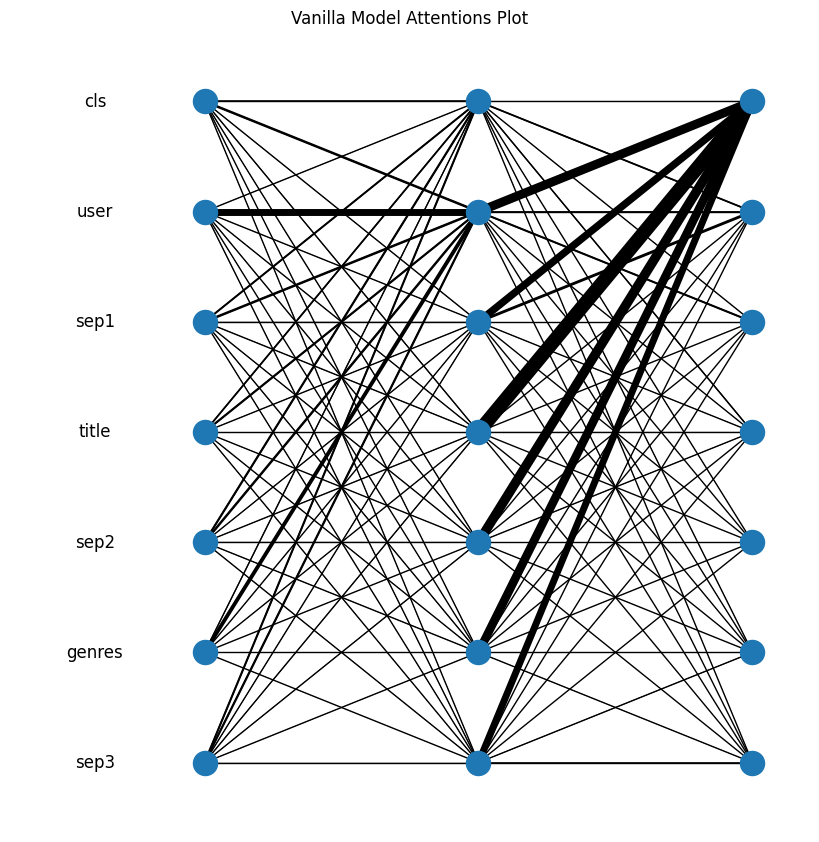

In [40]:
vanilla_token_labels = ["cls", "user", "sep1", "title", "sep2", "genres", "sep3"]
plot_attention_graph(vanilla_attentions, vanilla_token_labels, "Vanilla Model Attentions Plot", weight_coef=10, save_path="./images/Vanilla_Attentions.png")

In [41]:
KGE_DIMENSION_PROMPT = 4
KGE_DIMENSION_ADDING = 128
path_to_prompt_attentions = PROMPT_ATTENTIONS_PATH.format(KGE_DIMENSION_PROMPT) # replace with the respective path
path_to_embedding_attentions = ADDING_ATTENTIONS_PATH.format(KGE_DIMENSION_ADDING) # replace with the respective path
path_to_prompt_df = PROMPT_TOKENS_PATH.format(KGE_DIMENSION_PROMPT)
path_to_embedding_df = ADDING_TOKENS_PATH.format(KGE_DIMENSION_ADDING)
prompt_attentions = load_attentions(path_to_prompt_attentions, path_to_df=path_to_prompt_df, split = "val")
embedding_attentions = load_attentions(path_to_embedding_attentions, path_to_df=path_to_embedding_df, split = "val")
prompt_attentions.shape, embedding_attentions.shape

(torch.Size([51426, 11, 11, 2]), torch.Size([51426, 11, 11, 2]))

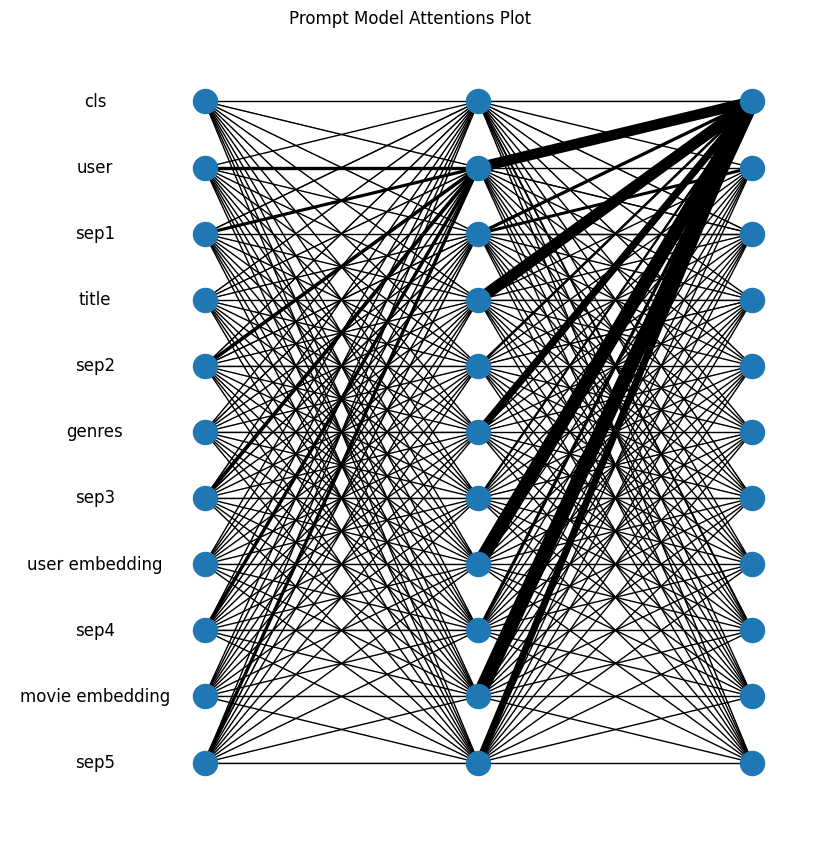

In [42]:
embedding_token_labels = ["cls", "user", "sep1", "title", "sep2", "genres", "sep3", "user embedding", "sep4", "movie embedding", "sep5"]
plot_attention_graph(prompt_attentions, embedding_token_labels, "Prompt Model Attentions Plot", weight_coef=10, save_path="./images/Prompt_Attentions.png")

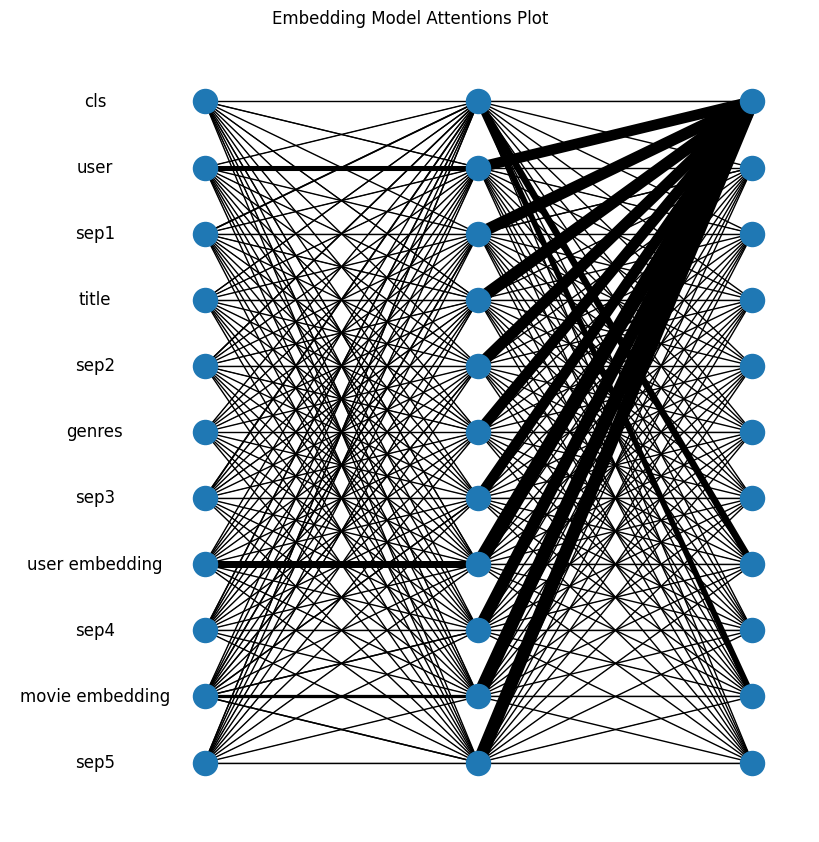

In [43]:
plot_attention_graph(embedding_attentions, embedding_token_labels, "Embedding Model Attentions Plot", weight_coef=10, save_path="./images/Embedding_Attentions.png")